In [15]:
%load_ext jupyter_black

In [16]:
from glob import glob
import xarray as xr
import dask.dataframe as ddf

file = glob("/workspaces/griblib/data/mrms/*.grib2")[0]


def open_grib(grib_file: str) -> xr.Dataset:
    with xr.open_dataset(grib_file, engine="cfgrib", chunks={}) as ds:
        ds: xr.Dataset = ds.rename({"unknown": "value"}).drop(["heightAboveSea", "time", "step", "valid_time"])
        return ds


ds = open_grib(file)
ds

<xarray.Dataset>
Dimensions:    (latitude: 3500, longitude: 7000)
Coordinates:
  * latitude   (latitude) float64 54.99 54.98 54.98 54.97 ... 20.03 20.02 20.01
  * longitude  (longitude) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0
Data variables:
    value      (latitude, longitude) float32 dask.array<chunksize=(3500, 7000), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2022-06-30T07:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [18]:
df = ds.to_dataframe().reset_index()
# longitude conversion 0~360 to -180~180
df["longitude"] = (df["longitude"] + 180) % 360 - 180
df

,latitude,longitude,value
0,54.995,-129.995000,2.3
1,54.995,-129.985000,2.3
2,54.995,-129.975000,2.4
3,54.995,-129.965000,2.5
4,54.995,-129.955000,2.6
...,...,...,...
24499995,20.005,-60.045002,0.0
24499996,20.005,-60.035002,0.0
24499997,20.005,-60.025002,0.0
24499998,20.005,-60.015002,0.0


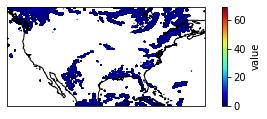

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def scatter_plot(df: pd.DataFrame):

    ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())

    ax.coastlines("50m")

    ax.set_extent(
        [
            *df["longitude"].agg(["min", "max"]),
            *df["latitude"].agg(["min", "max"]),
        ],
        ccrs.PlateCarree(),
    )

    df.plot(
        kind="scatter",
        y="latitude",
        x="longitude",
        c="value",
        ax=ax,
        alpha=np.where(df["value"] > 0, 1, 0),
        cmap=plt.get_cmap("jet"),
        s=0.1,
        # figsize=(16, 12),
        # **kwargs,
    )


df.reset_index().pipe(scatter_plot)

In [23]:
import rasterio as rio